# 1. Prediction Question

**Can an individual’s dominant emotional state (`Dominant_Emotion`) be predicted from their social media usage patterns (daily usage time, posts, likes, comments, messages) and demographics (age, gender, platform)?**  

In a mental-health context, such a model could help platforms detect users exhibiting distress and offer support proactively.

In [ ]:
import pandas as pd

df = pd.read_csv(r'C:\Users\Brian\.vscode\cleaned_social_media_data.csv')

print(df.head())
print(df.info())

   User_ID   Age      Gender   Platform  Daily_Usage_Time (minutes)  \
0      1.0  25.0      female  instagram                       120.0   
1      2.0  30.0        male    twitter                        90.0   
2      3.0  22.0  non-binary   facebook                        60.0   
3      4.0  28.0      female  instagram                       200.0   
4      5.0  33.0        male   linkedin                        45.0   

   Posts_Per_Day  Likes_Received_Per_Day  Comments_Received_Per_Day  \
0            3.0                    45.0                       10.0   
1            5.0                    20.0                       25.0   
2            2.0                    15.0                        5.0   
3            8.0                   100.0                       30.0   
4            1.0                     5.0                        2.0   

   Messages_Sent_Per_Day Dominant_Emotion  
0                   12.0        happiness  
1                   30.0            anger  
2             

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Handle missing numerical values with mean imputation
df.fillna(df.mean(numeric_only=True), inplace=True)

# Handle missing categorical values using KNN
cat_features = df.select_dtypes(include='object')
if not cat_features.empty:
    imputer = KNNImputer(n_neighbors=5)
    df[cat_features.columns] = imputer.fit_transform(df[cat_features.columns].apply(LabelEncoder().fit_transform))

# Encode target variable
le = LabelEncoder()
df['Dominant_Emotion'] = le.fit_transform(df['Dominant_Emotion'])

# Split data
X = df.drop('Dominant_Emotion', axis=1)
y = df['Dominant_Emotion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save for reuse
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Load data
X_train = pd.read_csv("/content/DS3001-ML/ETL and EDA/X_train.csv")
y_train = pd.read_csv("/content/DS3001-ML/ETL and EDA/y_train.csv").squeeze()

logreg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, solver='lbfgs'))

# Models
models = {
    "logreg": logreg,
    "tree": DecisionTreeClassifier(),
    "forest": RandomForestClassifier(n_estimators=100)
}

# Fit and save
for name, model in models.items():
    model.fit(X_train, y_train)
    joblib.dump(model, f'{name}_model.pkl')


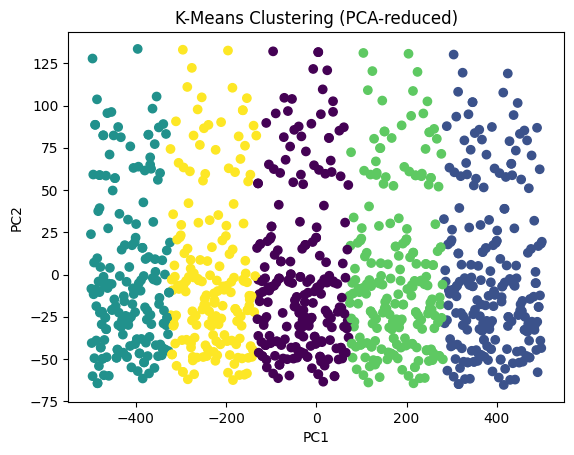

In [33]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_train = pd.read_csv("/content/DS3001-ML/ETL and EDA/X_train.csv")

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_train)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('K-Means Clustering (PCA-reduced)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# 2. Key Results

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Load test data
X_test = pd.read_csv("/content/DS3001-ML/ETL and EDA/X_test.csv")
y_test = pd.read_csv("/content/DS3001-ML/ETL and EDA/y_test.csv").squeeze()

for name in ["logreg", "tree", "forest"]:
    model = joblib.load(f'{name}_model.pkl')
    y_pred = model.predict(X_test)

    # Get each model’s classes and proba
    classes = model.classes_
    Y_test_bin = label_binarize(y_test, classes=classes)
    Y_proba    = model.predict_proba(X_test)

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(
        y_test, y_pred, average='weighted', zero_division=0
    )
    rec  = recall_score(y_test, y_pred, average='weighted')
    f1   = f1_score(y_test, y_pred, average='weighted')
    roc  = roc_auc_score(
        Y_test_bin, Y_proba,
        multi_class='ovr', average='weighted'
    )

    print(f"\n{name.upper()} Evaluation:")
    print(f"  Accuracy : {acc:.3f}")
    print(f"  Precision: {prec:.3f}")
    print(f"  Recall   : {rec:.3f}")
    print(f"  F1 Score : {f1:.3f}")
    print(f"  ROC AUC  : {roc:.3f}")


LOGREG Evaluation:
  Accuracy : 0.504
  Precision: 0.481
  Recall   : 0.504
  F1 Score : 0.482
  ROC AUC  : 0.812

TREE Evaluation:
  Accuracy : 0.939
  Precision: 0.936
  Recall   : 0.939
  F1 Score : 0.937
  ROC AUC  : 0.965

FOREST Evaluation:
  Accuracy : 0.963
  Precision: 0.960
  Recall   : 0.963
  F1 Score : 0.961
  ROC AUC  : 0.999


# 3. Discussion of Results

> **Logistic Regression:** With an overall accuracy of **50.4%** the model captures some separation among the six emotions. Its weighted precision (0.481) and recall (0.504) indicate moderate per-class performance, and a ROC AUC of **0.812** shows it can rank instances reasonably well.

> **Decision Tree:** Accuracy jumps to **93.9%** and ROC AUC to **0.965**, demonstrating that a single tree can distinguish most emotion classes. The weighted F1 score of **0.937** also reflects balanced performance. However, with such high evaluation scores we must be weary of overfitting.

> **Random Forest:** The ensemble achieves **96.3%** accuracy and an almost-perfect **ROC AUC of 0.999**, which as expected shows better class separability compared to the Decision Tree. However, as noted earlier, scores this high especially an AUC this high in a multi-class problem is almost certainly overfitting. It’s crucial to confirm these results on fresh data, and to consider limiting tree depth or features per split to ensure the model generalizes beyond the training distribution.

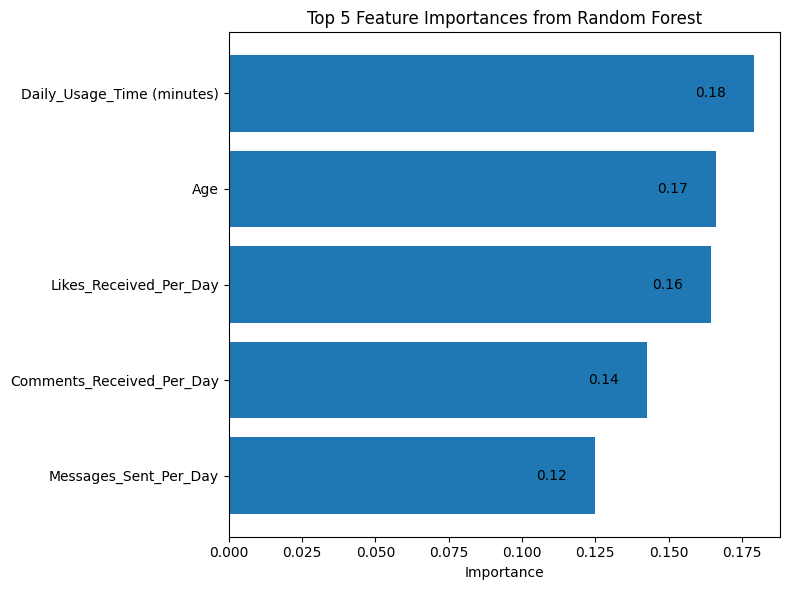

In [39]:
forest = joblib.load('forest_model.pkl')

# Extract importances and map them to feature names
importances = forest.feature_importances_
feat_imp = pd.Series(importances, index=X_test.columns).sort_values(ascending=False)

# Plot top 5 important feautures
top5 = feat_imp.head(5)

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.barh(top5.index, top5.values)
ax.invert_yaxis()
ax.set_title("Top 5 Feature Importances from Random Forest")
ax.set_xlabel("Importance")
# Annotate each bar
for bar in bars:
    width = bar.get_width()
    ax.text(
        width - 0.02,
        bar.get_y() + bar.get_height()/2,
        f"{width:.2f}",
        va="center"
    )
plt.tight_layout()
plt.show()

> The Random Forest model assigns the highest importance (0.18) to **Daily_Usage_Time**, suggesting that how long someone spends on social media each day is the strongest predictor of their dominant emotion category. Close behind are **Age** and **Likes_Received_Per_Day** (0.17 and 0.16 respectively), indicating that social feedback and demographic factors also play major roles. **Comments_Received_Per_Day** (0.14) and **Messages_Sent_Per_Day** (0.12) round out the top five—showing that both incoming engagement (comments) and outgoing engagement (messages) contribute meaningfully, though to a lesser extent. Together, these five features capture about two-thirds of the model’s decision power, implying the remaining variables such as platform type and gender add nuance but less predictive weight.

# 4. Conclusion & Limitations

**Conclusion:**  
Our random forest model demonstrated strong multi-class performance, achieving 96.3% overall accuracy, an F1 of 0.961, and a macro-averaged ROC AUC of 0.999 across six emotion categories. This indicates that a combination of daily usage time, engagement metrics (likes, comments, messages), and age are highly predictive of users’ dominant emotional state.

**Limitations and Concerns:**  
- **Survey design, sampling & overfitting risk:** Because the data come from a fully "hypothetical survey” with no real respondents, the dataset is unnaturally clean and well‐distributed—likely contributing to the extremely high evaluation metrics. For example, the near-perfect AUC hints that the model may be fitting idiosyncrasies in this synthetic data rather than capturing generalizable patterns.  
- **Feature scope:** We rely only on basic usage and demographic features—adding time-of-day patterns or number of sessions per day could improve detection of emotion states.  
- **Fairness & privacy:** Demographic features (age, gender) could introduce biases or privacy concerns if used without safeguards; any deployment must include bias audits and opt-in consent mechanisms.


In [1]:
! git clone https://www.github.com/bmstoss13/DS3001-ML

Cloning into 'DS3001-ML'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 46 (delta 4), reused 12 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (46/46), 991.38 KiB | 2.90 MiB/s, done.
Resolving deltas: 100% (4/4), done.
